In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold, SetStyle
SetStyle()

# Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "n_dim": 1,
                "n_mc": 100000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 100000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 10000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut": True ,
                "efficiency": 0.1,
                "acceptance": 0.1,
                "empty_value": -5.0,
}

In [3]:
ToyModel = GaussianToy(data_params)

# Define background subtraction classifier

In [4]:
bkg_true = torch.cat([ToyModel.data_rec[ToyModel.data_rec_mask.bool()], ToyModel.mc_background_rec])
weights_true = torch.cat([torch.ones_like(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()]), torch.ones_like(ToyModel.mc_background_rec[:,0]) * -1])
bkg_false = ToyModel.data_rec[ToyModel.data_rec_mask.bool()]
weights_false = torch.ones_like(bkg_false[:,0])

In [5]:
background_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [6]:
background_classifier = Classifier(dims_in = 1, params = background_classifier_params)

In [7]:
background_classifier.train_classifier(bkg_true, bkg_false, weights_true, weights_false)

Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2509663105010986 after time 3.7
    Finished epoch 6 with average loss 1.2499183416366577 after time 24.9
    Finished epoch 12 with average loss 1.2490158081054688 after time 45.7
    Finished epoch 18 with average loss 1.2492784261703491 after time 67.1
    Finished epoch 24 with average loss 1.2495721578598022 after time 88.9
    Finished epoch 29 with average loss 1.248582124710083 after time 107.1


In [8]:
background_weights = background_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
background_weights = background_weights * len(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()])/ background_weights.sum()

In [9]:
if not os.path.exists("Plots"):
    os.makedirs("Plots")
with PdfPages(f"Plots/background_suppression.pdf") as out:
    plot_reweighted_distribution(out, 
                                 ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].cpu().detach().numpy(),
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(),
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(), 
                                 reweighted_weights=background_weights.cpu().detach().numpy(),
                                 range=[-3,4], labels=[r"$\text{signal} |_r$" , "reweighted","data $(s+b)|_r$"], name="x_1")    

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:193: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:194: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:193: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


# Acceptance classifier

In [10]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [11]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [12]:
acceptance_classifier = Classifier(dims_in=1, params=acceptance_classifier_params)

In [13]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 9.009008007117437
Training classifier for 270 epochs with lr 0.0001
    Finished epoch 0 with average loss 6.69329833984375 after time 0.3
    Finished epoch 54 with average loss 3.2517528533935547 after time 18.5
    Finished epoch 108 with average loss 3.251913070678711 after time 36.7
    Finished epoch 162 with average loss 3.2517991065979004 after time 54.9
    Finished epoch 216 with average loss 3.251678705215454 after time 73.6
    Finished epoch 269 with average loss 3.251797914505005 after time 91.6


In [14]:
acceptance = acceptance_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()], return_weights=False)

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
        8.0000e+00, 2.9000e+01, 1.7600e+02, 3.7810e+03, 9.4935e+04]),
 array([0.86873943, 0.87201601, 0.87529254, 0.87856913, 0.88184565,
        0.88512224, 0.88839883, 0.89167535, 0.89495194, 0.89822847,
        0.90150505]),
 <BarContainer object of 10 artists>)

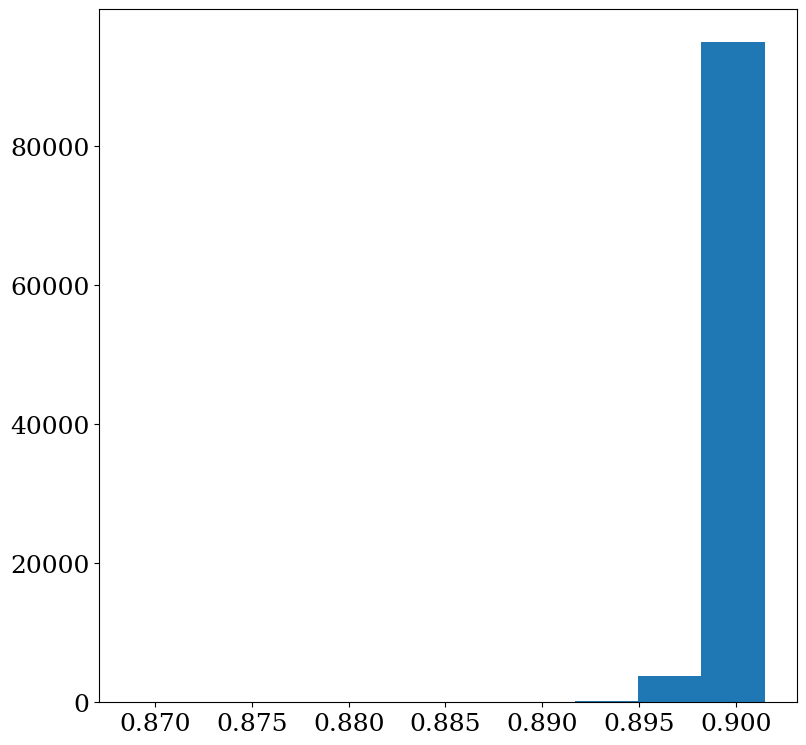

In [15]:
plt.hist(acceptance.cpu().detach().numpy())
#Ideally a diract delta at 0.90 in this case

In [16]:
with PdfPages(f"Plots/acceptance_effects.pdf") as out:
    plot_reweighted_distribution(out, 
                                 ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:data_params["n_data"]].bool()) & (ToyModel.data_gen_mask.bool())].cpu().detach().numpy(),
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(),
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(), 
                                 reweighted_weights=(acceptance*background_weights).cpu().detach().numpy(),
                                 fake_weights=background_weights.cpu().detach().numpy(),
                                 range=[-3,4], labels=[r"$\text{signal}|_{g,r}$" , "$\epsilon$ (data -b)","data -b"], name="x_1")

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:193: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:194: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:193: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


# Train CFM unfolding network

In [17]:
iterative_unfolding_params = { "iterations" : 5,
                               "generator": { "hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000},
                               "classifier": {"hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000}}

Starting with the 0.iteration.
Initalize unfolder
using conditional model
Training generative model for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.0843770503997803 after time 2.1
    Finished epoch 6 with average loss 0.7197598814964294 after time 14.1
    Finished epoch 12 with average loss 0.7126355171203613 after time 26.1
    Finished epoch 18 with average loss 0.7149876356124878 after time 38.1
    Finished epoch 24 with average loss 0.7051762938499451 after time 50.1
    Finished epoch 29 with average loss 0.7012702226638794 after time 60.1
unfold data


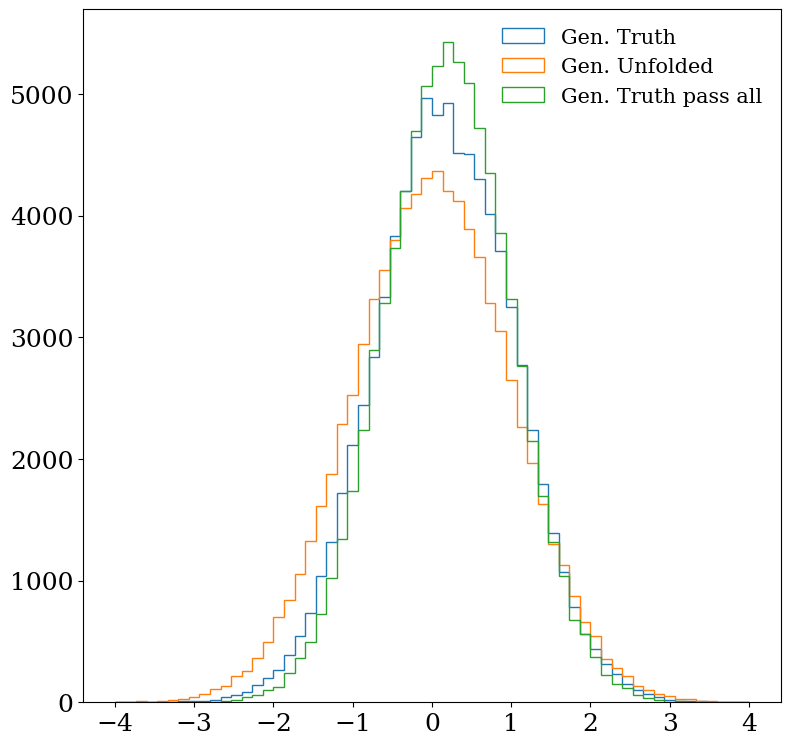

Starting with the 1.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2419383525848389 after time 3.0
    Finished epoch 6 with average loss 1.2388839721679688 after time 21.0
    Finished epoch 12 with average loss 1.238871693611145 after time 39.2
    Finished epoch 18 with average loss 1.2390936613082886 after time 56.8
    Finished epoch 24 with average loss 1.2390729188919067 after time 74.9
    Finished epoch 29 with average loss 1.238821268081665 after time 89.5
using conditional model
Training generative model for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5676921606063843 after time 2.0
    Finished epoch 6 with average loss 0.561863124370575 after time 13.7
    Finished epoch 12 with average loss 0.560845136642456 after time 25.6
    Finished epoch 18 with average loss 0.5600695610046387 after time 37.3
    Finished epoch 24 with average loss 0.5598458647727966 after time 49.5
    Finished epoch 29 with

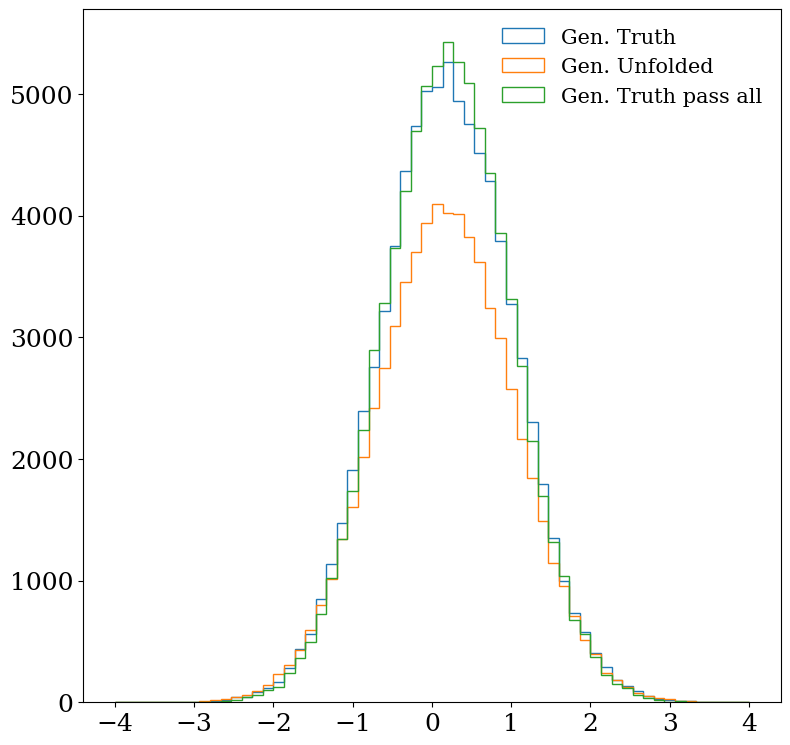

Starting with the 2.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.1359379291534424 after time 3.0
    Finished epoch 6 with average loss 1.1354962587356567 after time 21.0
    Finished epoch 12 with average loss 1.135541558265686 after time 39.1
    Finished epoch 18 with average loss 1.1354131698608398 after time 56.8
    Finished epoch 24 with average loss 1.1354814767837524 after time 74.1
    Finished epoch 29 with average loss 1.1354678869247437 after time 88.9
using conditional model
Training generative model for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5514909625053406 after time 2.0
    Finished epoch 6 with average loss 0.5535509586334229 after time 13.7
    Finished epoch 12 with average loss 0.5553779006004333 after time 25.4
    Finished epoch 18 with average loss 0.5520997047424316 after time 37.1
    Finished epoch 24 with average loss 0.5507984757423401 after time 48.7
    Finished epoch 29 w

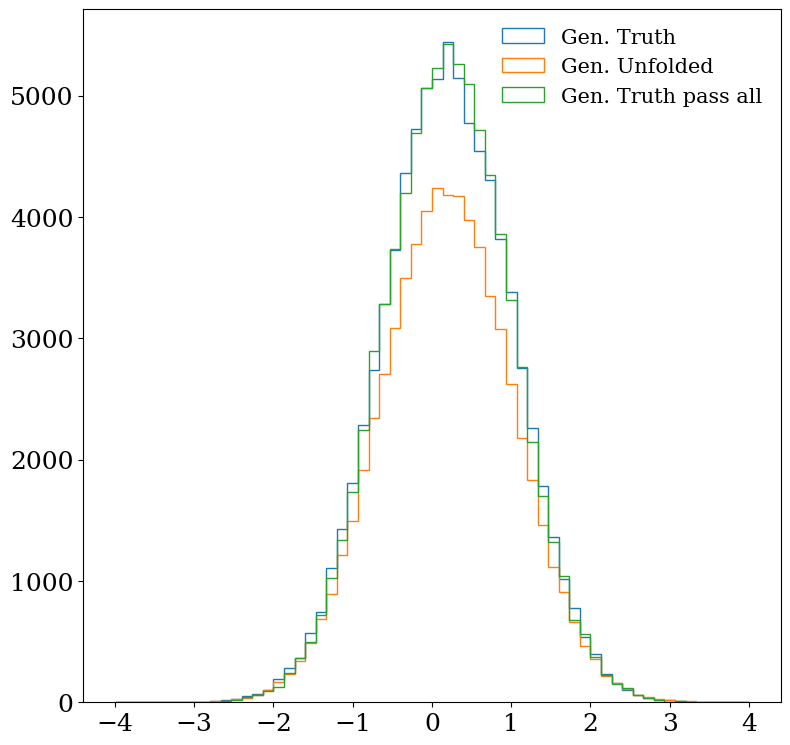

Starting with the 3.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.1339391469955444 after time 3.1
    Finished epoch 6 with average loss 1.1337438821792603 after time 21.2
    Finished epoch 12 with average loss 1.1337064504623413 after time 39.1
    Finished epoch 18 with average loss 1.1336873769760132 after time 56.5
    Finished epoch 24 with average loss 1.1337125301361084 after time 74.0
    Finished epoch 29 with average loss 1.1337487697601318 after time 88.7
using conditional model
Training generative model for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5472038984298706 after time 2.0
    Finished epoch 6 with average loss 0.5515691041946411 after time 13.8
    Finished epoch 12 with average loss 0.5535062551498413 after time 25.7
    Finished epoch 18 with average loss 0.5451626181602478 after time 37.6
    Finished epoch 24 with average loss 0.5476149916648865 after time 49.6
    Finished epoch 29 

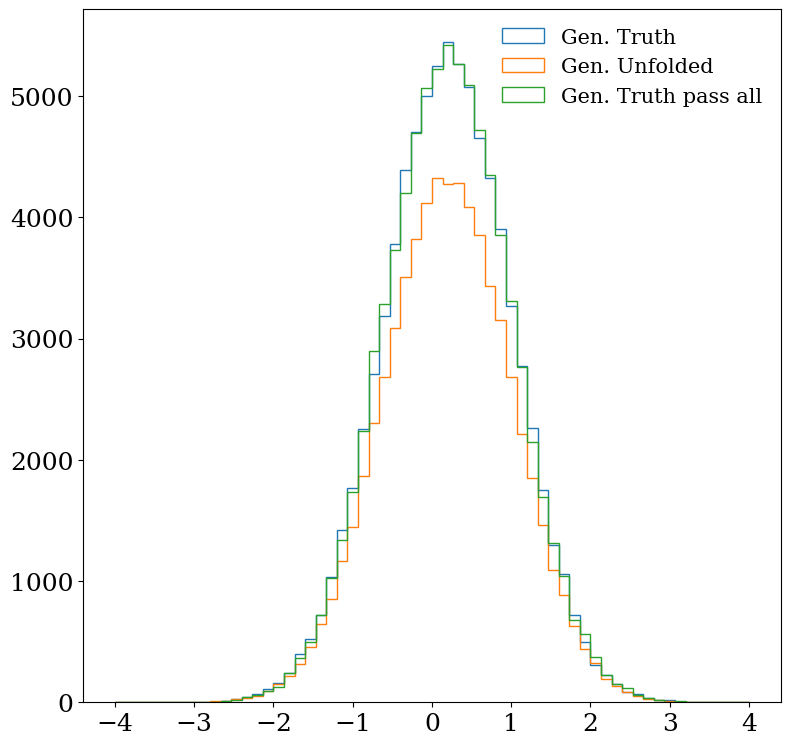

Starting with the 4.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.1361955404281616 after time 2.9
    Finished epoch 6 with average loss 1.1358656883239746 after time 20.7
    Finished epoch 12 with average loss 1.135927438735962 after time 38.5
    Finished epoch 18 with average loss 1.1360350847244263 after time 56.3
    Finished epoch 24 with average loss 1.1359164714813232 after time 74.1
    Finished epoch 29 with average loss 1.1358872652053833 after time 88.8
using conditional model
Training generative model for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5420939326286316 after time 2.0
    Finished epoch 6 with average loss 0.5450664162635803 after time 13.9
    Finished epoch 12 with average loss 0.5466669201850891 after time 25.9
    Finished epoch 18 with average loss 0.5487049221992493 after time 37.8
    Finished epoch 24 with average loss 0.5431479215621948 after time 49.8
    Finished epoch 29 w

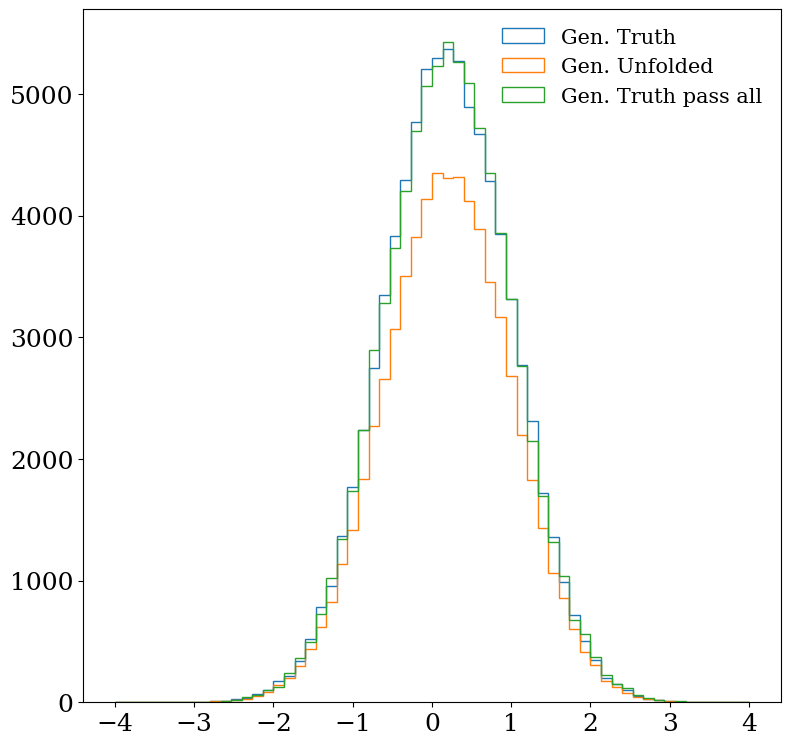

In [18]:
for i in range(iterative_unfolding_params["iterations"]):
    print(f"Starting with the {i}.iteration.")
    if i == 0:
        print("Initalize unfolder")
        unfolder = CFM(dims_x = 1, dims_c = 1, params = iterative_unfolding_params["generator"])
        mc_gen = ToyModel.mc_gen[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_rec = ToyModel.mc_rec[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_weights = torch.ones_like(mc_rec[:, 0])
        data_weights = acceptance * background_weights
    if i > 0 :
        iterative_classifier = Classifier(dims_in = 1, params = iterative_unfolding_params["classifier"])
        iterative_classifier.train_classifier(data_unfold, mc_gen, data_weights, mc_weights)
        mc_weights *= iterative_classifier.evaluate(mc_gen)
        
    unfolder.train(mc_gen, mc_rec, mc_weights)
    print("unfold data")
    data_unfold = unfolder.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
    fig, axes = plt.subplots()
    axes.hist(data_unfold[:,0].cpu().detach().numpy(), weights=data_weights.cpu().detach().numpy(), bins=60, histtype="step", range=[-4,4],label="Gen. Truth")
    axes.hist(mc_gen[:,0].cpu().detach().numpy(), weights=mc_weights.cpu().detach().numpy(), bins=60, histtype='step', range=[-4,4],label="Gen. Unfolded")
    axes.hist(ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:data_params["n_data"]].bool())&(ToyModel.data_gen_mask.bool())].cpu().detach().numpy(), bins=60, range=[-4,4], histtype="step", label="Gen. Truth pass all")
    plt.legend()  # Display the legend
    plt.show()

In [19]:
with PdfPages(f"Plots/prior_dependence.pdf") as out:
    plot_prior_unfold(out, 
                      ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:data_params["n_data"]].bool()) & (ToyModel.data_gen_mask.bool())].cpu().detach().numpy(),
                      ToyModel.mc_gen[:,0][(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())].cpu().detach().numpy(),
                      data_unfold[:, 0].cpu().detach().numpy(),
                      unfolded_weights=(acceptance*background_weights).cpu().detach().numpy(),
                      range=[-3,4], name="x_1")

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:295: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:296: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:295: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


# Train efficiency classifier

In [20]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [21]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [22]:
efficiency_classifier = Classifier(dims_in = 1, params = efficiency_classifier_params)

In [23]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 9.016026711185308
Training classifier for 270 epochs with lr 0.0001
    Finished epoch 0 with average loss 6.51806640625 after time 0.3
    Finished epoch 54 with average loss 3.252760887145996 after time 18.6
    Finished epoch 108 with average loss 3.252795457839966 after time 37.0
    Finished epoch 162 with average loss 3.252481460571289 after time 55.3
    Finished epoch 216 with average loss 3.2524242401123047 after time 73.8
    Finished epoch 269 with average loss 3.2523529529571533 after time 91.8


In [24]:
efficiency_weights = efficiency_classifier.evaluate(data_unfold, return_weights=False)

In [25]:
data_weights =acceptance*background_weights/ efficiency_weights

In [26]:
with PdfPages(f"Plots/efficiency_effects.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_gen[:,0][(ToyModel.data_gen_mask.bool())].cpu().detach().numpy(),
                                 data_unfold[:,0].cpu().detach().numpy(),
                                 data_unfold[:,0].cpu().detach().numpy(),
                                 reweighted_weights=(acceptance*background_weights/efficiency_weights).cpu().detach().numpy(),
                                 fake_weights=(acceptance*background_weights).cpu().detach().numpy(),
                                 range=[-3,4], labels=[r"$\text{gen}|_g$" , r"$\text{unfolded} / \delta$","unfolded"], name="x_1")

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:193: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:194: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:193: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


In [27]:
with PdfPages(f"Plots/final_unfolding.pdf") as out:
    plot_naive_unfold(out, 
                      ToyModel.data_gen[:, 0][(ToyModel.data_gen_mask.bool())].cpu().detach().numpy(),
                      ToyModel.data_rec[:, 0].cpu().detach().numpy(),
                      data_unfold[:, 0].cpu().detach().numpy(),
                      unfolded_weights=data_weights.cpu().detach().numpy(),
                      range=[-3, 4], name="x_1")

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:88: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:89: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:88: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
